### **ConvLSTM for Chlorophyl Density Prediction**

This notebook aims to develop a spatiotemporal deep learning model using a Convolutional Long Short-Term Memory (ConvLSTM) network to predict chlorophyll concentration in the North Sea region. The model leverages various environmental features, such as iron (Fe) concentration, oxygen (O2), nitrate (NO3), pH, and silicate (Si), to predict chlorophyll levels over time.

#### **Objectives**
- **Predict Chlorophyll Concentration**: Accurately forecast chlorophyll concentration levels based on historical environmental data, helping in understanding and managing marine ecosystems.
- **Analyze Model Performance**: Evaluate the model's predictive capabilities across different time steps and spatial locations, and assess its generalization to unseen data.

#### **Data Overview**
- **Dataset**: The dataset contains monthly observations of several environmental variables from 1993 to 2022, spanning 360 months. Key features include Fe, O2, NO3, pH, Si, and chlorophyll concentration.
- **Spatial Coverage**: The data is collected across various latitude and longitude points in the North Sea region, forming a grid of observational data.

#### **Methodology**
- **Data Preparation**: The data is first normalized and transformed into a 3D matrix format suitable for input into the ConvLSTM model.
- **Model Architecture**: A ConvLSTM network is employed, capable of capturing both spatial and temporal dependencies in the data.
- **Training and Validation**: The model is trained on a portion of the data (first 288 months) and validated on the remaining unseen data (last 72 months).
- **Evaluation**: Model performance is evaluated using metrics such as Mean Squared Error (MSE) and visualized through various plots, including predicted vs. actual chlorophyll maps, error maps, and time-series plots.

By utilizing advanced deep learning techniques, this project seeks to improve the prediction of chlorophyll concentrations, providing valuable insights for marine ecology and environmental monitoring.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
biodata= pd.read_pickle('nndata-northsea.pk')

In [3]:
biodata

,latitude,longitude,time,fe,o2,no3,ph,si,chl
0,50.0,-24.0,0,0.000088,281.567322,2.080662,8.110415,2.138924,0.370446
1,50.0,-24.0,1,0.000163,280.282562,2.993226,8.113768,2.575200,0.412862
2,50.0,-24.0,2,0.000238,275.026337,3.804201,8.108490,2.938094,0.429694
3,50.0,-24.0,3,0.000323,271.002106,5.135850,8.099180,3.282241,0.679693
4,50.0,-24.0,4,0.000184,274.887634,3.234359,8.110825,2.160934,0.678685
...,...,...,...,...,...,...,...,...,...
3748675,72.0,5.0,355,0.000040,290.753601,4.557200,8.016018,1.678630,0.280854
3748676,72.0,5.0,356,0.000033,293.561920,4.706186,8.029039,1.817170,0.246417
3748677,72.0,5.0,357,0.000036,300.114838,5.200759,8.040764,1.990027,0.216296
3748678,72.0,5.0,358,0.000050,305.402954,5.702006,8.052160,2.131294,0.119115


### **Data Preparation and Conversion to Tensors**

This section prepares the data for training by normalizing the features and converting the dataset into a format suitable for input into the ConvLSTM model.

- **Data Normalization**: Standardizes the environmental features to have a mean of 0 and a standard deviation of 1, facilitating better model training.
- **Tensor Conversion**: Converts the data into 3D tensors representing the time, latitude, longitude, and feature dimensions, which are then used as input to the ConvLSTM model.
- **Output Shapes**: Prints the shapes of the training and test tensors to verify correctness.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare data
traindata = biodata.loc[biodata.time < 287].copy() # Select training data up to time step 286
testdata = biodata.loc[biodata.time >= 287].copy() # Select test data from time step 287 onwards
features = ['fe', 'o2', 'no3', 'ph', 'si', 'chl'] # List of features used for model input
X_train = traindata[features].values
X_test = testdata[features].values

# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Store normalized features as a list of vectors in the DataFrame
traindata['vec'] = list(X_train_norm)
testdata['vec'] = list(X_test_norm)

def format3dmat(df_vals):
    """
    Convert a 2D array of vectors into a 3D tensor.

    Args:
        df_vals (np.ndarray): 2D array where each entry is a vector of feature values.

    Returns:
        torch.Tensor: 3D tensor with shape (height, width, depth).
    """
    h, w = df_vals.shape
    d = len(df_vals[0,0])
    emptymat = np.zeros((h, w, d))
    for i in range(h):
        for j in range(w):
            for k in range(d):
                emptymat[i, j, k] = df_vals[i, j][k]
    return torch.tensor(emptymat)

def fulldf_to_tensor(df):
    """
    Convert the entire DataFrame into a 4D tensor suitable for ConvLSTM input.

    Args:
        df (pd.DataFrame): DataFrame with time, latitude, longitude, and feature vectors.

    Returns:
        torch.Tensor: 4D tensor with shape (time_steps, depth, height, width).
    """
    mats = []
    tmin = df['time'].min()
    tmax = df['time'].max()
    for t in range(tmin, tmax):
        # Pivot the DataFrame to create a 2D array with latitude and longitude as indices
        mats.append(format3dmat(df.loc[df.time == t].pivot(index='latitude',
                                                          columns=['longitude'],
                                                          values='vec').values))
    return torch.permute(torch.stack(mats), (0, 3, 2, 1)).float()

# Convert to tensors
traintensor = fulldf_to_tensor(traindata)
testtensor = fulldf_to_tensor(testdata)

print(f'Training tensor shape: {traintensor.shape}')  
print(f'Test tensor shape: {testtensor.shape}')


Training tensor shape: torch.Size([286, 6, 117, 89])
Test tensor shape: torch.Size([72, 6, 117, 89])


In [5]:
traintensor = fulldf_to_tensor(traindata)
testtensor = fulldf_to_tensor(testdata)

# Add batch dimension and ensure correct format
traintensor = traintensor.unsqueeze(0)  # Adding batch dimension
testtensor = testtensor.unsqueeze(0)    # Adding batch dimension

print(f'Training tensor shape (with batch dimension): {traintensor.shape}')  # Should be (1, 347, 6, 117, 89)


Training tensor shape (with batch dimension): torch.Size([1, 286, 6, 117, 89])


### **ConvLSTM Model Definition and Forward Pass**

This section defines the core components of the ConvLSTM model and its variants:

- **ConvLSTMCell**: Represents a single ConvLSTM cell, which combines convolutional and LSTM operations to capture spatial and temporal dependencies in the data.
- **ConvLSTM**: Builds a multi-layer ConvLSTM network using multiple ConvLSTMCells, allowing for deeper learning of spatiotemporal patterns.
- **NextImagePredictor**: A wrapper model around ConvLSTM to predict the next image in a sequence. It applies a convolutional layer to each output time step of the ConvLSTM, making predictions for the next time step.

The models are designed to handle 4D tensor inputs representing time, features, height, and width.


In [13]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        """
        Initialize a ConvLSTM cell.

        Args:
            input_dim (int): Number of channels in the input tensor.
            hidden_dim (int): Number of channels in the hidden state.
            kernel_size (int or tuple): Size of the convolutional kernel.
            bias (bool): Whether to add a learnable bias to the convolutions. Default is True.
        """
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2 if isinstance(kernel_size, int) else (kernel_size[0] // 2, kernel_size[1] // 2)
        self.bias = bias

        # Convolution layer to process combined input and hidden state
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        """
        Perform a forward pass of the ConvLSTM cell.

        Args:
            input_tensor (torch.Tensor): Input data of shape (batch, channels, height, width).
            cur_state (tuple): Current hidden and cell states (h_cur, c_cur).

        Returns:
            tuple: Next hidden state (h_next) and cell state (c_next).
        """
        h_cur, c_cur = cur_state

        # Concatenate input and hidden state along the channel dimension
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)

        # Split the convolution result into four parts for LSTM gates
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        # Compute next cell and hidden states
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        """
        Initialize the hidden and cell states for the LSTM.

        Args:
            batch_size (int): Number of sequences in a batch.
            image_size (tuple): Tuple of (height, width) for the spatial dimensions.

        Returns:
            tuple: Initialized hidden state (h0) and cell state (c0).
        """
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True):
        """
        Initialize a multi-layer ConvLSTM network.

        Args:
            input_dim (int): Number of channels in the input tensor.
            hidden_dim (list): List of hidden dimensions for each layer.
            kernel_size (list or tuple): Size of the convolutional kernels.
            num_layers (int): Number of ConvLSTM layers.
            batch_first (bool): If True, input and output tensors are provided as (batch, time, channels, height, width).
            bias (bool): Whether to add a learnable bias to the convolutions. Default is True.
        """
        super(ConvLSTM, self).__init__()

        # Ensure kernel_size is a list of tuples
        if isinstance(kernel_size, tuple):
            kernel_size = [kernel_size] * num_layers
        elif isinstance(kernel_size, list):
            if len(kernel_size) != num_layers:
                raise ValueError(f'Length of kernel_size list ({len(kernel_size)}) does not match num_layers ({num_layers})')
        else:
            raise ValueError(f'kernel_size must be a tuple or list of tuples, got {type(kernel_size)}')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias

        self.cell_list = nn.ModuleList()

        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            self.cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                               hidden_dim=self.hidden_dim[i],
                                               kernel_size=self.kernel_size[i],
                                               bias=self.bias))

    def forward(self, input_tensor, hidden_state=None):
        """
        Perform a forward pass of the multi-layer ConvLSTM network.

        Args:
            input_tensor (torch.Tensor): Input data of shape (batch, time, channels, height, width).
            hidden_state (list, optional): Initial hidden and cell states for each layer. If None, states are initialized.

        Returns:
            tuple: List of layer outputs and last hidden states for all layers.
        """
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Initialize hidden states if not provided
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)

        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        """
        Initialize hidden states for all layers.

        Args:
            batch_size (int): Number of sequences in a batch.
            image_size (tuple): Tuple of (height, width) for the spatial dimensions.

        Returns:
            list: List of initialized hidden and cell states for each layer.
        """
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not isinstance(kernel_size, tuple):
            kernel_size = [kernel_size] * 2
        if not (isinstance(kernel_size, list) or isinstance(kernel_size, tuple)):
            raise ValueError('`kernel_size` must be tuple or list, got "{}"'.format(type(kernel_size)))

class NextImagePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        """
        Initialize the NextImagePredictor model.

        Args:
            input_dim (int): Number of channels in the input tensor.
            hidden_dim (list): List of hidden dimensions for each ConvLSTM layer.
            kernel_size (tuple): Size of the convolutional kernels.
            num_layers (int): Number of ConvLSTM layers.
        """
        super(NextImagePredictor, self).__init__()

        self.convlstm = ConvLSTM(input_dim=input_dim,
                                 hidden_dim=hidden_dim,
                                 kernel_size=kernel_size,
                                 num_layers=num_layers,
                                 batch_first=True,
                                 bias=True)

        # Convolutional layer to transform ConvLSTM outputs
        self.conv = nn.Conv2d(in_channels=hidden_dim[-1], out_channels=input_dim,
                              kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        """
        Perform a forward pass through the NextImagePredictor model.

        Args:
            x (torch.Tensor): Input data of shape (batch, time, channels, height, width).

        Returns:
            torch.Tensor: Predicted next image for each time step.
        """
        # Get outputs for all time steps from the ConvLSTM layer
        layer_output_list, _ = self.convlstm(x)
        
        # Apply the final convolution to each time step's output
        all_time_outputs = []
        for t in range(layer_output_list[-1].size(1)):  # Iterate over time steps
            time_step_output = layer_output_list[-1][:, t, :, :, :]  # Extract the t-th time step output
            all_time_outputs.append(self.conv(time_step_output))  # Apply convolution

        # Stack along the time dimension to form a sequence
        return torch.stack(all_time_outputs, dim=1)



In [7]:
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
# Define DataLoader for batching
batch_size = 8  # can adjust depending on gpu memory
train_dataset = TensorDataset(traintensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:

print(torch.cuda.is_available())  # Should return True if CUDA is available


True


### **Training the ConvLSTM Model with Mixed Precision**

In this section, we train the ConvLSTM model using mixed precision to leverage GPU acceleration effectively.

- **Model Initialization**: The `NextImagePredictor` model is initialized with specific parameters:
  - `input_dim`: Number of input features.
  - `hidden_dim`: A list defining the number of hidden units for each ConvLSTM layer.
  - `kernel_size`: The size of the convolutional kernels.
  - `num_layers`: Number of ConvLSTM layers in the model.

- **Mixed Precision Training**: To optimize memory usage and speed up computations, we employ mixed precision training using PyTorch's `autocast` and `GradScaler`:
  - `autocast` automatically selects the precision for each operation.
  - `GradScaler` helps prevent underflow during backpropagation by scaling the loss.

- **Training Loop**: The model is trained for a specified number of epochs:
  - For each epoch, the model's parameters are updated based on the mean squared error (MSE) loss between the predicted and actual chlorophyll concentrations.
  - Only the last time step's output is compared during loss computation, focusing on the final prediction accuracy.

- **Saving the Model**: The trained model's state is saved to a file for future use, enabling continued training or inference without retraining from scratch.


In [13]:
from torch.cuda.amp import GradScaler, autocast

# Model parameters
input_dim = 6  # Number of input features
hidden_dim = [64, 64, 64]  # Number of hidden units per layer
kernel_size = (3, 3)  # Kernel size for convolutions
num_layers = 3  # Number of ConvLSTM layers

# Initialize the model
model = NextImagePredictor(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()  # Mixed precision training

# Check if a GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch_input = batch[0].to(device)  # Move data to GPU

        # Use autocast for mixed precision training
        with autocast():  # Simply use autocast without any arguments
            output = model(batch_input)  # Forward pass
            loss = criterion(output, batch_input[:, -1])  # Compare only the last time step

        # Backward pass and optimization with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        # Clear cache to avoid memory issues
        torch.cuda.empty_cache()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

torch.save(model.state_dict(), 'conv_lstm_model.pth')
print("Model saved as conv_lstm_model.pth")


C:\Users\josep\AppData\Local\Temp\ipykernel_10092\34217746.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
C:\Users\josep\AppData\Local\Temp\ipykernel_10092\34217746.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Simply use autocast without any arguments


Epoch [1/10], Loss: 0.7193
Epoch [2/10], Loss: 0.7009
Epoch [3/10], Loss: 0.6465
Epoch [4/10], Loss: 0.4722
Epoch [5/10], Loss: 0.4921
Epoch [6/10], Loss: 0.3632
Epoch [7/10], Loss: 0.3377
Epoch [8/10], Loss: 0.3501
Epoch [9/10], Loss: 0.2746
Epoch [10/10], Loss: 0.2562
Model saved as conv_lstm_model.pth


In [9]:
from torch.cuda.amp import GradScaler, autocast

# Model parameters
input_dim = 6  # Number of input features
hidden_dim = [64, 64, 64]  # Number of hidden units per layer
kernel_size = (3, 3)  # Kernel size for convolutions
num_layers = 3  # Number of ConvLSTM layers

# Initialize the model
model = NextImagePredictor(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()  # Mixed precision training

# Check if a GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model.to(device)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch_input = batch[0].to(device)  # Move data to GPU

        # Use autocast for mixed precision training
        with autocast():
            output = model(batch_input)  # Forward pass for all time steps
            loss = criterion(output, batch_input[:, -1])  # Compare only the last time step

        # Backward pass and optimization with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        # Clear cache to avoid memory issues
        torch.cuda.empty_cache()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

torch.save(model.state_dict(), 'conv_lstm_model_20_time.pth')
print("Model saved as conv_lstm_model_20_time.pth")


C:\Users\josep\AppData\Local\Temp\ipykernel_11844\2108867043.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
C:\Users\josep\AppData\Local\Temp\ipykernel_11844\2108867043.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/20], Loss: 0.7257
Epoch [2/20], Loss: 0.7058
Epoch [3/20], Loss: 0.6237
Epoch [4/20], Loss: 0.4562
Epoch [5/20], Loss: 0.4291
Epoch [6/20], Loss: 0.3681
Epoch [7/20], Loss: 0.3397
Epoch [8/20], Loss: 0.3074
Epoch [9/20], Loss: 0.2777
Epoch [10/20], Loss: 0.2608
Epoch [11/20], Loss: 0.2431
Epoch [12/20], Loss: 0.2238
Epoch [13/20], Loss: 0.2005
Epoch [14/20], Loss: 0.1870
Epoch [15/20], Loss: 0.1779
Epoch [16/20], Loss: 0.1726
Epoch [17/20], Loss: 0.1635
Epoch [18/20], Loss: 0.1532
Epoch [19/20], Loss: 0.1453
Epoch [20/20], Loss: 0.1392
Model saved as conv_lstm_model_20_time.pth


In [14]:
# Reload the model if saved 
model = NextImagePredictor(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers)
model.load_state_dict(torch.load('conv_lstm_model_20.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    # Perform predictions across all time steps
    test_predictions = model(testtensor.to(device)).cpu().numpy()

print(f"Shape of test_predictions: {test_predictions.shape}")  # Expected shape: (1, 72, 6, 117, 89)




C:\Users\josep\AppData\Local\Temp\ipykernel_11844\2721835716.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('conv_lstm_model_20.pth'))


Shape of test_predictions: (1, 72, 6, 117, 89)


In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract predicted and actual chlorophyll concentrations
test_predictions_chl = test_predictions[:, :, 5, :, :]  # Chlorophyll is in channel index 5
test_actuals_chl = testtensor[:, :, 5, :, :].cpu().numpy()  

# Flatten the arrays for MSE calculation
test_predictions_flat = test_predictions_chl.flatten()
test_actuals_flat = test_actuals_chl.flatten()

# Calculate MSE and RMSE
mse = mean_squared_error(test_actuals_flat, test_predictions_flat)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 0.7892
Root Mean Squared Error (RMSE): 0.8884


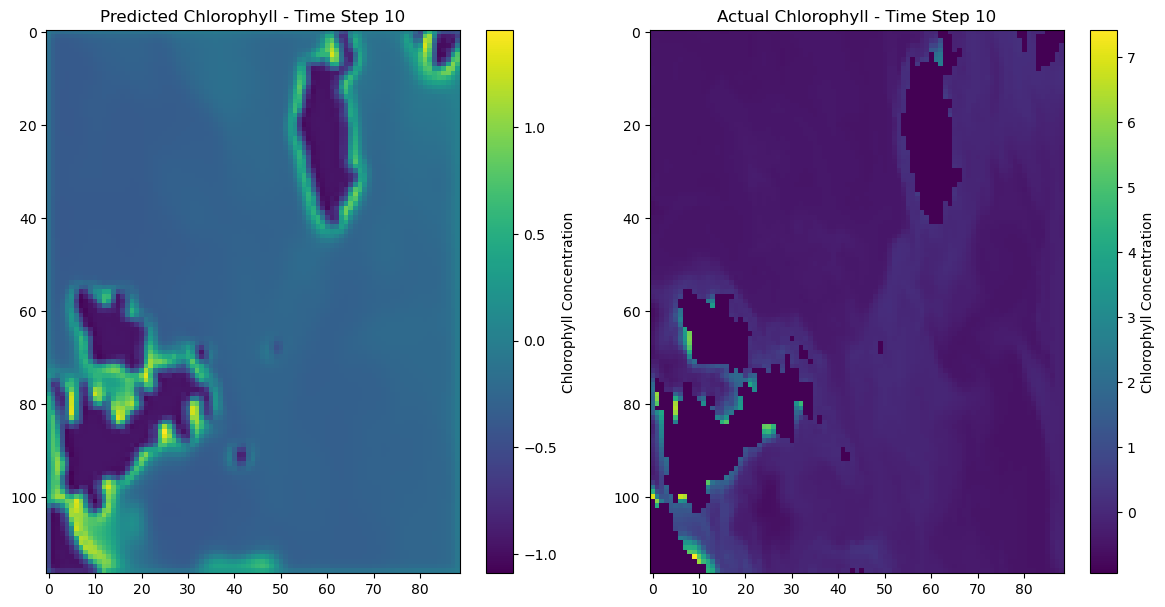

In [16]:
import matplotlib.pyplot as plt

# Choose a specific time step to visualize
time_step = 10  # Example time step index

# Extract chlorophyll concentration for the chosen time step
predicted_chl_map = test_predictions[0, time_step, 5, :, :] 
actual_chl_map = test_actuals_chl[0, time_step, :, :]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(predicted_chl_map, cmap='viridis')
plt.title(f'Predicted Chlorophyll - Time Step {time_step}')
plt.colorbar(label='Chlorophyll Concentration')

plt.subplot(1, 2, 2)
plt.imshow(actual_chl_map, cmap='viridis')
plt.title(f'Actual Chlorophyll - Time Step {time_step}')
plt.colorbar(label='Chlorophyll Concentration')

plt.tight_layout()
plt.show()


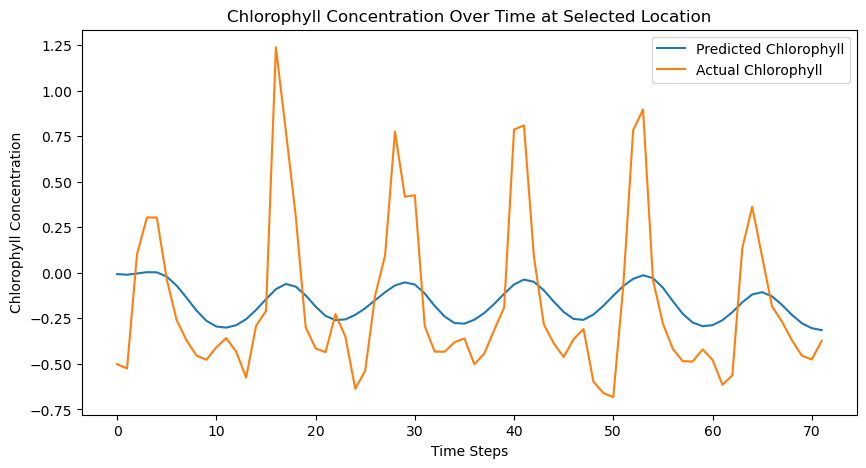

In [23]:
# Choose a specific location (latitude, longitude)
latitude_idx = 40  # Example index for latitude
longitude_idx = 40  # Example index for longitude

# time series for chlorophyll at the selected location
predicted_series = test_predictions[0, :, 5, latitude_idx, longitude_idx]  # Adjust index for chlorophyll
actual_series = test_actuals_chl[0, :, latitude_idx, longitude_idx]

plt.figure(figsize=(10, 5))
plt.plot(predicted_series, label='Predicted Chlorophyll')
plt.plot(actual_series, label='Actual Chlorophyll')
plt.xlabel('Time Steps')
plt.ylabel('Chlorophyll Concentration')
plt.title('Chlorophyll Concentration Over Time at Selected Location')
plt.legend()
plt.show()


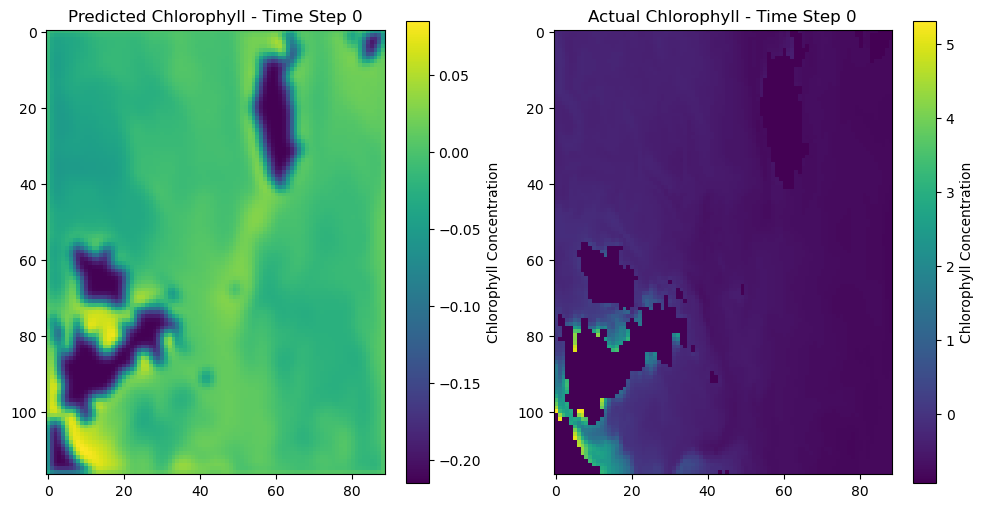

In [35]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Initialize the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pred_ax, actual_ax = axes

# Initialize the images to be updated
predicted_im = pred_ax.imshow(test_predictions[0, 0, 5, :, :], cmap='viridis', animated=True)
actual_im = actual_ax.imshow(test_actuals_chl[0, 0, :, :], cmap='viridis', animated=True)

pred_ax.set_title('Predicted Chlorophyll')
actual_ax.set_title('Actual Chlorophyll')
plt.colorbar(predicted_im, ax=pred_ax, label='Chlorophyll Concentration')
plt.colorbar(actual_im, ax=actual_ax, label='Chlorophyll Concentration')

# Update function for animation
def update(frame):
    # Update the data for the animation
    predicted_im.set_array(test_predictions[0, frame, 5, :, :])
    actual_im.set_array(test_actuals_chl[0, frame, :, :])
    pred_ax.set_title(f'Predicted Chlorophyll - Time Step {frame}')
    actual_ax.set_title(f'Actual Chlorophyll - Time Step {frame}')
    return predicted_im, actual_im

# Create the animation and assign it to 'ani' to prevent garbage collection
ani = animation.FuncAnimation(fig, update, frames=test_predictions.shape[1], blit=True)

# Display the animation
plt.show()

# Save the animation as a GIF after the animation is shown
ani.save('chlorophyll_animation_1.gif', writer='pillow', fps=2)  



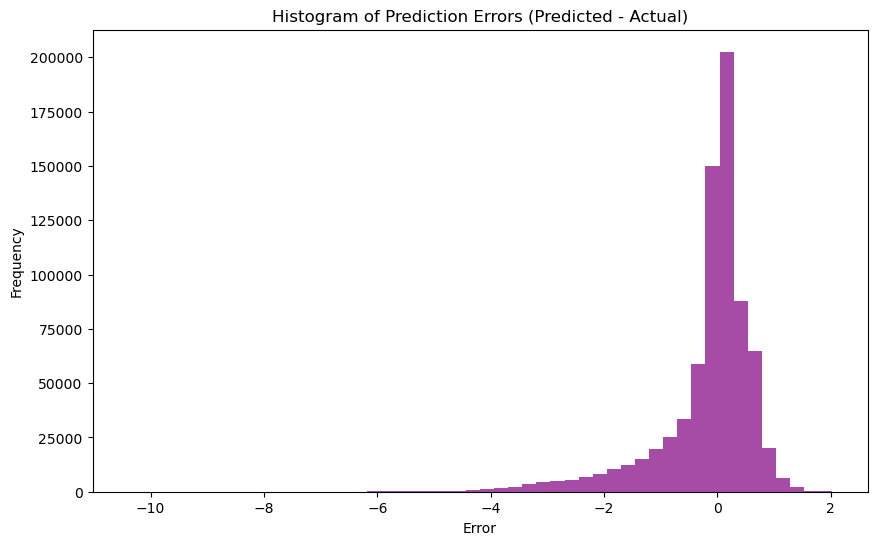

In [29]:
import numpy as np

# Flatten the predicted and actual arrays for histogram
predicted_flat = test_predictions[:, :, 5, :, :].flatten()
actual_flat = test_actuals_chl[:, :, :, :].flatten()

# Calculate the error
error = predicted_flat - actual_flat

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(error, bins=50, color='purple', alpha=0.7)
plt.title('Histogram of Prediction Errors (Predicted - Actual)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


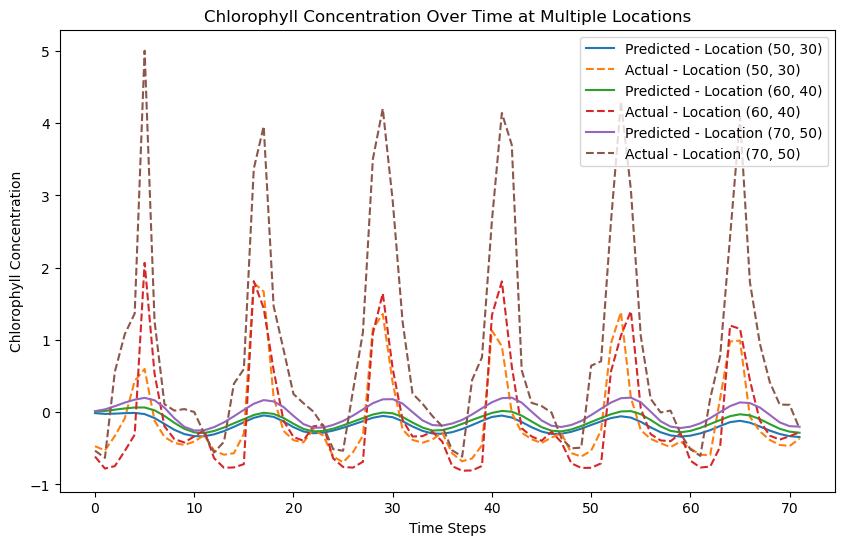

In [32]:
# Choose multiple locations (latitude, longitude indices)
locations = [(50, 30), (60, 40), (70, 50)]  # Example locations

plt.figure(figsize=(10, 6))
for loc in locations:
    latitude_idx, longitude_idx = loc
    predicted_series = test_predictions[0, :, 5, latitude_idx, longitude_idx]
    actual_series = test_actuals_chl[0, :, latitude_idx, longitude_idx]
    
    plt.plot(predicted_series, label=f'Predicted - Location {loc}')
    plt.plot(actual_series, linestyle='--', label=f'Actual - Location {loc}')

plt.xlabel('Time Steps')
plt.ylabel('Chlorophyll Concentration')
plt.title('Chlorophyll Concentration Over Time at Multiple Locations')
plt.legend()
plt.show()


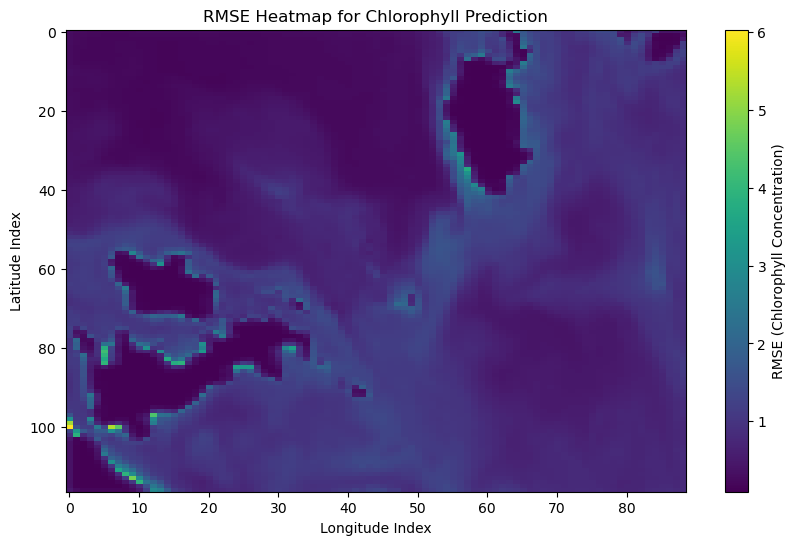

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_predictions and test_actuals_chl are defined
# test_predictions: (batch_size, time_steps, channels, height, width)
# test_actuals_chl: (batch_size, time_steps, height, width)

# Extract chlorophyll predictions and actuals
predicted_chl = test_predictions[:, :, 5, :, :]  # Chlorophyll is assumed to be at channel index 5
actual_chl = test_actuals_chl[:, :, :, :]  # Actual chlorophyll concentrations

# Calculate RMSE for each spatial location across all time steps
rmse_map = np.sqrt(np.mean((predicted_chl - actual_chl) ** 2, axis=(0, 1)))

# Plot RMSE heatmap
plt.figure(figsize=(10, 6))
plt.imshow(rmse_map, cmap='viridis', aspect='auto')
plt.colorbar(label='RMSE (Chlorophyll Concentration)')
plt.title('RMSE Heatmap for Chlorophyll Prediction')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()


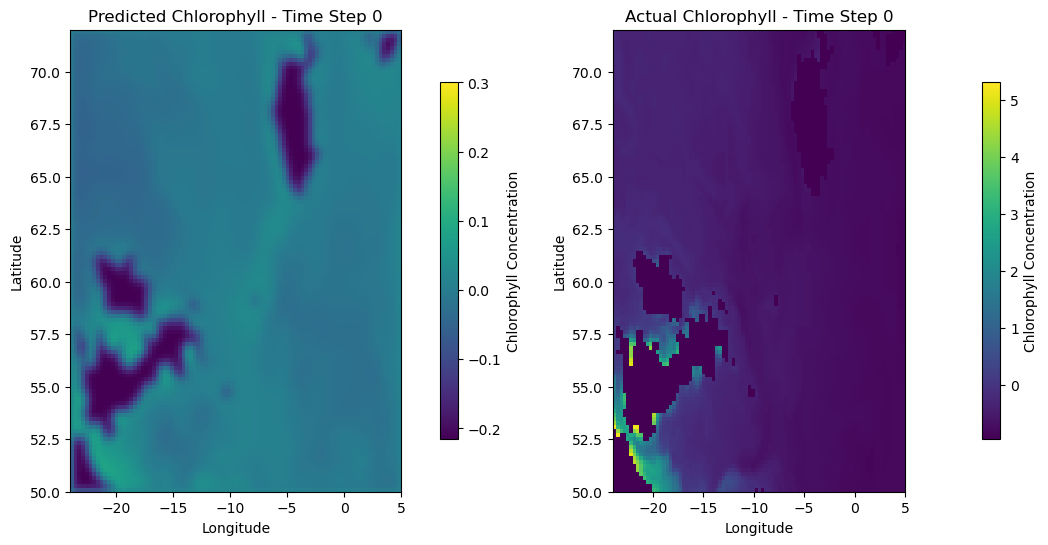

In [47]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Assuming longitude and latitude ranges
lon_min, lon_max = biodata['longitude'].min(), biodata['longitude'].max()
lat_min, lat_max = biodata['latitude'].min(), biodata['latitude'].max()

# Initialize the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pred_ax, actual_ax = axes

# Determine color scale limits separately for each subplot
vmin_pred = test_predictions[0, 0, 5, :, :].min()
vmax_pred = 0.3  # Set vmax for the predicted chlorophyll plot
vmin_actual = test_actuals_chl[0, 0, :, :].min()
vmax_actual = test_actuals_chl[0, 0, :, :].max()

# Initialize the images to be updated
predicted_im = pred_ax.imshow(test_predictions[0, 0, 5, :, :], cmap='viridis', animated=True,
                              extent=[lon_min, lon_max, lat_min, lat_max], vmin=vmin_pred, vmax=vmax_pred,
                              aspect='auto')  # Set aspect to 'auto' or 'equal'
actual_im = actual_ax.imshow(test_actuals_chl[0, 0, :, :], cmap='viridis', animated=True,
                             extent=[lon_min, lon_max, lat_min, lat_max], vmin=vmin_actual, vmax=vmax_actual,
                             aspect='auto')  # Set aspect to 'auto' or 'equal'

# Set axis titles and labels
pred_ax.set_title('Predicted Chlorophyll')
actual_ax.set_title('Actual Chlorophyll')
pred_ax.set_xlabel('Longitude')
pred_ax.set_ylabel('Latitude')
actual_ax.set_xlabel('Longitude')
actual_ax.set_ylabel('Latitude')

# First colorbar for predicted plot, positioned with more padding
cbar_pred = fig.colorbar(predicted_im, ax=pred_ax, orientation='vertical', fraction=0.046, pad=0.1, label='Chlorophyll Concentration')

# Second colorbar for actual plot, placed to the right side with more padding
cbar_actual = fig.colorbar(actual_im, ax=actual_ax, orientation='vertical', fraction=0.046, pad=0.2, label='Chlorophyll Concentration')

# Adjust layout to provide more room between elements
plt.subplots_adjust(wspace=0.4)  # Increase space between subplots

# Update function for animation
def update(frame):
    # Update the data for the animation
    predicted_im.set_array(test_predictions[0, frame, 5, :, :])
    actual_im.set_array(test_actuals_chl[0, frame, :, :])
    pred_ax.set_title(f'Predicted Chlorophyll - Time Step {frame}')
    actual_ax.set_title(f'Actual Chlorophyll - Time Step {frame}')
    return predicted_im, actual_im

# Create the animation and assign it to 'ani' to prevent garbage collection
ani = animation.FuncAnimation(fig, update, frames=test_predictions.shape[1], blit=True)

# Display the animation
plt.show()

# Save the animation as a GIF after the animation is shown
ani.save('chlorophyll_animation_vmax_0.3_with_padding_1.gif', writer='pillow', fps=2)  # Adjust fps as needed
